In [128]:
#Import deps 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import ADASYN
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import Lasso
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ... 

### Introduction
What makes the perfect bottle of wine? 

Wine is a major industry, with sales projected to steadily grow beyond $40 billion USD by 2029. [Source](https://www.statista.com/statistics/922403/global-wine-market-size/)

For the longest time, the secrets of the timeless art of winemaking were restricted to the intuitions and implicit knowledge of the vintners themselves. Today it is possible to apply the techniques of machine learning to analyze the chemical components of wine to determine how they influence the quality rating of the wine.

This study conducts machine learning analysis on the chemical constitutents of 6497 different wines (1599 reds and 4898 white ) to identify the predictive relationships between these features and wine quality. 

The purpose of this study is to show how machine learning can be applied to commercial pursuits and potentially improve sales and production quality of products. 


In [129]:
# Import Data 
all_wine_raw_df = pd.read_csv('./Wine_data_both.csv') 
red_wine_df = pd.read_csv('./Wine_data_red.csv')
white_wine_df = pd.read_csv('./Wine_data_white.csv')


In [130]:
# Inspect raw data 
print('All wine data types', all_wine_raw_df.info())
print('all wine value counts', all_wine_raw_df['quality'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  Wine                  6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB
All wine data types None
all wine value counts quality
6    283

### Data Preparation, Encoding & Feature Engineering

One of the biggest challenges we faced was an significantly imbalanced data set. The minority classes, with quality =(3, 4, 9) were underepresented by several orders of magnitude compared to the majority class with quality=9 just having 5 samples and quality=6, the most frequent approx 3,000. 

Initial experiments were unable to come up with a model with sufficient sensitivity to predict minority classes with this sort of discrepancy. So we had to get clever. 

The cell below takes the mean values of the minority classes and uses it as the "typical value" for that class. Since 9 is so under-represented, it likely wouldn't be realistic to generalize from its average with only n=5 data points. So the decision was made to merge quality=8 into it. And do do the same for 3s and 4's. We argue this loss in target resolution is made up for improved model performance. 

In [131]:
# Upgrade all 8s to become 9s and 3s to become 4s
all_wine_raw_df.loc[all_wine_raw_df['quality'] == 8, 'quality'] = 9
all_wine_raw_df.loc[all_wine_raw_df['quality'] == 3, 'quality'] = 4

all_9s = all_wine_raw_df.drop(columns='Wine')[all_wine_raw_df['quality'] == 9]
all_4s = all_wine_raw_df.drop(columns=['Wine'])[all_wine_raw_df['quality'] == 4]
all_6s = all_wine_raw_df.drop(columns=['Wine'])[all_wine_raw_df['quality'] == 6]


mean_all_9s = all_9s.mean()
mean_all_4s = all_4s.mean()
mean_all_6s = all_6s.mean()
# Compare the means (difference between highest and lowest rated wines)
mean_difference_high_to_low = mean_all_9s - mean_all_4s
mean_difference_high_to_average = mean_all_9s - mean_all_6s

# Display the results
print("Mean values for highest rated wines (quality == 9):")
print(mean_all_9s)
print("\nMean values for lowest rated wines (quality == 3):")
print(mean_all_4s)
print("\nMean values for average rated wines (quality == 6):")
print(mean_all_6s)
print("\nDifference in mean values between highest and lowest:")
print(mean_difference_high_to_low)
print("\nDifference in mean values between highest and average:")
print(mean_difference_high_to_average)


Mean values for highest rated wines (quality == 9):
fixed acidity             6.850000
volatile acidity          0.291187
citric acid               0.333889
residual sugar            5.351010
chlorides                 0.040778
free sulfur dioxide      34.505051
total sulfur dioxide    117.479798
density                   0.992487
pH                        3.225354
sulphates                 0.511313
alcohol                  11.691414
quality                   9.000000
dtype: float64

Mean values for lowest rated wines (quality == 3):
fixed acidity             7.357724
volatile acidity          0.465163
citric acid               0.273374
residual sugar            4.273984
chlorides                 0.062126
free sulfur dioxide      22.902439
total sulfur dioxide    105.701220
density                   0.994944
pH                        3.234797
sulphates                 0.505732
alcohol                  10.184350
quality                   4.000000
dtype: float64

Mean values for average r

We then use the **generate_synthetic_samples** function to inject a number of statistically similar values into the sample set. 

It achieves this by using a multivariate normal distribution, which describes a set of random variables that may be correlated with each other, where each variable follows a normal distribution. 

In order realistially simulate the possibility of covariance between the different values of a single data entry, we pass the covariance matrix of the dataframe into np.random.multivariate_normal. It then multiplies this by a noise scale, ensuring that there the results resemble the average in the dataset without overly imitating it. 

In [132]:
def generate_synthetic_samples(mean_values, n_samples, noise_scale=0.03):
    synthetic_samples = np.random.multivariate_normal(
        mean=mean_values, 
        cov= all_wine_raw_df.drop(columns='Wine').cov() * noise_scale, 
        size=n_samples
    )
    return pd.DataFrame(synthetic_samples, columns=mean_values.index)

# Grab all the minority classes in the data and take their means, inject the magic # 30 
synthetic_9s = generate_synthetic_samples(mean_all_9s, 30)
synthetic_4s = generate_synthetic_samples(mean_all_4s, 30)
# Add the target column to the synthetic samples
synthetic_9s['quality'] = 9
synthetic_4s['quality'] = 4
# Combine synthetic samples with the original data
synthetic_data = pd.concat([synthetic_9s, synthetic_4s])
combined_data = pd.concat([all_wine_raw_df, synthetic_data])

Below we repeat the steps performed a few cells above to verify that the values of the updated data still resemble what they were originally.  

In [133]:
all_9s = combined_data.drop(columns='Wine')[combined_data['quality'] == 9]
all_4s = combined_data.drop(columns=['Wine'])[combined_data['quality'] == 4]
all_6s = combined_data.drop(columns=['Wine'])[combined_data['quality'] == 6]


synth_mean_all_9s = all_9s.mean()
synth_mean_all_4s = all_4s.mean()
# Compare the means (difference between highest and lowest rated wines)
synth_mean_difference_high_to_low = synth_mean_all_9s - synth_mean_all_4s
synth_mean_difference_high_to_average = mean_all_9s - mean_all_6s

# Display the results
print("Mean values for highest rated wines (quality == 9):")
print(synth_mean_all_9s)
print("\nMean values for lowest rated wines (quality == 3):")
print("\nMean values for average rated wines (quality == 6):")
print(mean_all_6s)
print("\nDifference in mean values between highest and lowest:")
print(synth_mean_difference_high_to_low)
print("\nDifference in mean values between highest and average:")
print(synth_mean_difference_high_to_average)


Mean values for highest rated wines (quality == 9):
fixed acidity             6.857212
volatile acidity          0.291222
citric acid               0.334282
residual sugar            5.354137
chlorides                 0.040808
free sulfur dioxide      34.494944
total sulfur dioxide    117.443870
density                   0.992486
pH                        3.225198
sulphates                 0.510182
alcohol                  11.695975
quality                   9.000000
dtype: float64

Mean values for lowest rated wines (quality == 3):

Mean values for average rated wines (quality == 6):
fixed acidity             7.177257
volatile acidity          0.313863
citric acid               0.323583
residual sugar            5.549753
chlorides                 0.054157
free sulfur dioxide      31.165021
total sulfur dioxide    115.410790
density                   0.994558
pH                        3.217726
sulphates                 0.532549
alcohol                  10.587553
quality                

Later, we apply cross validation techniques to verify the integrity of this synthetic data. 

In [134]:
# Manually encode the wine type, 0 is White, Red is 1
combined_data['wine type'] = all_wine_raw_df['Wine'].map({'White': 0, 'Red': 1})

# Define the feature and target variables
# Note: We learned what features to drop through EDA and in the optimizations performed below. 
X = combined_data.drop(columns=['quality', 'Wine', 'citric acid', 'chlorides', 'density', ], axis=1)
y =  combined_data['quality']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

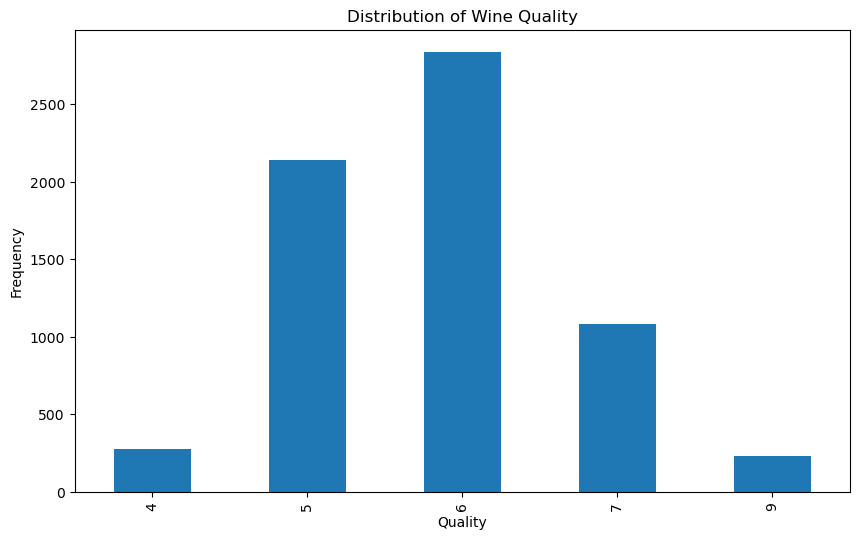

In [135]:
# Determine if data is balanced or imbalanced
plt.figure(figsize=(10, 6))
y.value_counts(sort=False).sort_index().plot(kind='bar')
plt.xlabel('Quality')
plt.ylabel('Frequency')
plt.title('Distribution of Wine Quality')
plt.show()

# Clustering or feature engineering by clumping 3s/4s/5s/ low  6s/ medium/ 7,8,9 high quality 

Since our data is still very imbalanced, we want apply a few techniques to compensate for it. One method is to calculate class weights, which will help inform the model to learn more from the minority classes. 

In [136]:
# Since our data is very imbalanced, lets try calculating class weights 
unique_classes = np.array([4, 5, 6, 7, 9])
class_weights = compute_class_weight(class_weight='balanced', classes=unique_classes, y=y_train)
class_weight_dict = {cls: weight for cls, weight in zip(unique_classes, class_weights)}

print(f'Class weights: {class_weight_dict}')

Class weights: {4: 4.746606334841629, 5: 0.6134502923976608, 6: 0.4623182018510357, 7: 1.2155272305909617, 9: 5.763736263736264}


Next we wanted to look into feature selection. We learned that the most significant features are 'residual sugar', 'free sulfur dioxide', 'total sulfur dioxide', and 'alcohol'. 


In [137]:
# Feature Selection and regularization : What features can we drop? 
# Here we learned that density and pH could be dropped
# Initialize Lasso regression
lasso = Lasso(alpha=0.1)  
lasso.fit(X_train, y_train)

y_pred_lasso = lasso.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_lasso)
print(f'Mean Squared Error: {mse}')

# Check selected features
selected_features = X_train.columns[lasso.coef_ != 0]
print(f'Selected Features: {selected_features}')


# Note: ElasticNet, which can be used both for feature selection and multicolinearity detection 
# basically tells us none of our features predict wine quality. Don't know how to interpret this
from sklearn.linear_model import ElasticNet

# Initialize and fit the Elastic Net model
elastic_net = ElasticNet(alpha=1.0, l1_ratio=0.5)  # l1_ratio is the mixing parameter
elastic_net.fit(X_train, y_train)

# Predict and evaluate
y_pred_enet = elastic_net.predict(X_test)
mse_enet = mean_squared_error(y_test, y_pred_enet)
print(f"Elastic Net Mean Squared Error: {mse_enet}")

# Coefficients
print(f"Elastic Net Coefficients: {elastic_net.coef_}")


# Calculate variance inflation factor for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

# Based on these results, we could consider dropping at least pH and density, and possibly also alcohol 

# Compute the correlation matrix
correlation_matrix = X.corr()

# Display the correlation matrix
print(correlation_matrix)


Mean Squared Error: 0.7329504986273824
Selected Features: Index(['residual sugar', 'free sulfur dioxide', 'total sulfur dioxide',
       'alcohol'],
      dtype='object')
Elastic Net Mean Squared Error: 0.943026638017781
Elastic Net Coefficients: [-0.         -0.         -0.          0.00670834 -0.00188055  0.
  0.          0.         -0.        ]
                feature         VIF
0         fixed acidity   35.229523
1      volatile acidity    9.782605
2        residual sugar    3.292982
3   free sulfur dioxide    8.752992
4  total sulfur dioxide   20.197913
5                    pH  141.154520
6             sulphates   19.098383
7               alcohol   93.578961
8             wine type    5.879176
                      fixed acidity  volatile acidity  residual sugar  \
fixed acidity              1.000000          0.219463       -0.112077   
volatile acidity           0.219463          1.000000       -0.196498   
residual sugar            -0.112077         -0.196498        1.000000  

In [138]:
# Note: Don't end up using, will likely drop
adasyn = ADASYN(random_state=42, n_neighbors=3)
X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)

### Scaling the Data


In [139]:
# Note, scaling data seems to throw everything out here, probably because nothing in the data is measured in universal units.
# Will likey drop
scaler = StandardScaler()

# Fit the scaler on the training data and transform the training data
X_train_resampled_scaled = scaler.fit_transform(X_resampled)
X_train_scaled = scaler.transform(X_train)
# Transform the testing data (use the same scaler fitted on the training data)
X_test_scaled = scaler.transform(X_test)

### Build Models

For our model we decided to use the versatile RandomizedTreeClassifier algorithm, which, after some experimentation with other algos proved to consistently give the best results.  

First, we did some hyperparameter tuning to try to find the best model. 

In [140]:
# Define a simpler parameter grid for RandomizedSearchCV
param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['sqrt', 'log2'],
}


In [141]:
# Define the actual model code using what we've learned and search for a best model 

# Initialize RFC
rfc = RandomForestClassifier(random_state=42, class_weight=class_weight_dict)
# Initialize the RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rfc,
    param_distributions=param_distributions,
    n_iter=50,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1 
)

# Perform the random search on the training data
random_search.fit(X_train, y_train)

# Get the best model
best_rfc = random_search.best_estimator_

# Predict on the scaled test data
y_pred_rfc = best_rfc.predict(X_test)

# Evaluate the best model
print("Best RFC Classification Report:")
print(classification_report(y_test, y_pred_rfc))
print("Best RFC Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rfc))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END criterion=log_loss, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END criterion=log_loss, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END criterion=log_loss, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END criterion=gini, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=5,

In [142]:
print(best_rfc)
classifier = RandomForestClassifier(class_weight=class_weight_dict, criterion='log_loss', max_depth=30, max_features='log2', n_estimators=500, random_state=42)
classifier.fit(X=X_train, y=y_train)
y_pred_best = classifier.predict(X_test)

print("Best RFC Classification Report:")
print(classification_report(y_test, y_pred_best))
print("Best RFC Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best))

RandomForestClassifier(class_weight={4: 4.746606334841629,
                                     5: 0.6134502923976608,
                                     6: 0.4623182018510357,
                                     7: 1.2155272305909617,
                                     9: 5.763736263736264},
                       max_depth=20, max_features='log2', n_estimators=500,
                       random_state=42)
Best RFC Classification Report:
              precision    recall  f1-score   support

           4       0.86      0.33      0.47        55
           5       0.73      0.73      0.73       428
           6       0.68      0.81      0.74       567
           7       0.70      0.55      0.61       216
           9       0.86      0.39      0.54        46

    accuracy                           0.70      1312
   macro avg       0.77      0.56      0.62      1312
weighted avg       0.71      0.70      0.70      1312

Best RFC Confusion Matrix:
[[ 18  31   5   1   0]
 [  3 313 110 

### Model Validation and Evaluation

Our model performs reasonably well for precision, however struggles with recall especially for the minority classes. 

#### Cross-Validation

Here we cross-validate the model using StratifiedKFold. We find that our cross validation scores are decent but not great.

In [143]:

# Define cross-validation strategy
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate the model using cross-validation when trained against synthetic data
cv_scores_synthetic_data = cross_val_score(best_rfc, X, y, cv=kfold, scoring='f1_weighted')

# Output the cross-validation scores against the da
print(f'Cross-Validation Score Against Synthetic Data: {cv_scores_synthetic_data}')
print(f'Mean Cross-Validation Score Against Synthetic Data: {np.mean(cv_scores_synthetic_data)}')


Cross-Validation Score Against Synthetic Data: [0.67180605 0.67257441 0.6793839  0.66291595 0.69420058]
Mean Cross-Validation Score Against Synthetic Data: 0.6761761790993523


As a control experiment, we run the same model against the raw data. The model is generall less capable across the board, but most notably, is entirely unable to detect the minority classes (quality= 3 and quality=9)

In [144]:
raw_data = pd.read_csv('./Wine_data_both.csv') 
X_raw = raw_data.drop(columns=['quality', 'Wine'])
y_raw = raw_data['quality']
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X_raw, y_raw, test_size=0.2, random_state=42, stratify=y_raw)
raw_classifier = RandomForestClassifier( class_weight=class_weight_dict, criterion='log_loss', max_depth=30, max_features='log2', n_estimators=500, random_state=42)
raw_classifier.fit(X=X_train_raw, y=y_train_raw)
y_pred_best_raw = raw_classifier.predict(X_test_raw)

print("Raw Data RFC Classification Report:")
print(classification_report(y_test_raw, y_pred_best_raw))
print("Raw Data Confusion Matrix:")
print(confusion_matrix(y_test_raw, y_pred_best_raw))

Raw Data RFC Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.75      0.14      0.24        43
           5       0.71      0.75      0.73       428
           6       0.65      0.77      0.70       567
           7       0.73      0.51      0.60       216
           8       0.86      0.31      0.45        39
           9       0.00      0.00      0.00         1

    accuracy                           0.68      1300
   macro avg       0.53      0.35      0.39      1300
weighted avg       0.69      0.68      0.67      1300

Raw Data Confusion Matrix:
[[  0   0   2   4   0   0   0]
 [  0   6  22  15   0   0   0]
 [  0   1 321 106   0   0   0]
 [  0   1  99 436  30   1   0]
 [  0   0  10  94 111   1   0]
 [  0   0   0  17  10  12   0]
 [  0   0   0   0   1   0   0]]


/opt/anaconda3/envs/ai_dev/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/ai_dev/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/ai_dev/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Evaluation & Interpretation 

Index(['fixed acidity', 'volatile acidity', 'residual sugar',
       'free sulfur dioxide', 'total sulfur dioxide', 'pH', 'sulphates',
       'alcohol', 'wine type'],
      dtype='object')
[0.09439224 0.13929064 0.10670187 0.12954934 0.12127988 0.09845762
 0.10640138 0.1913729  0.01255414]


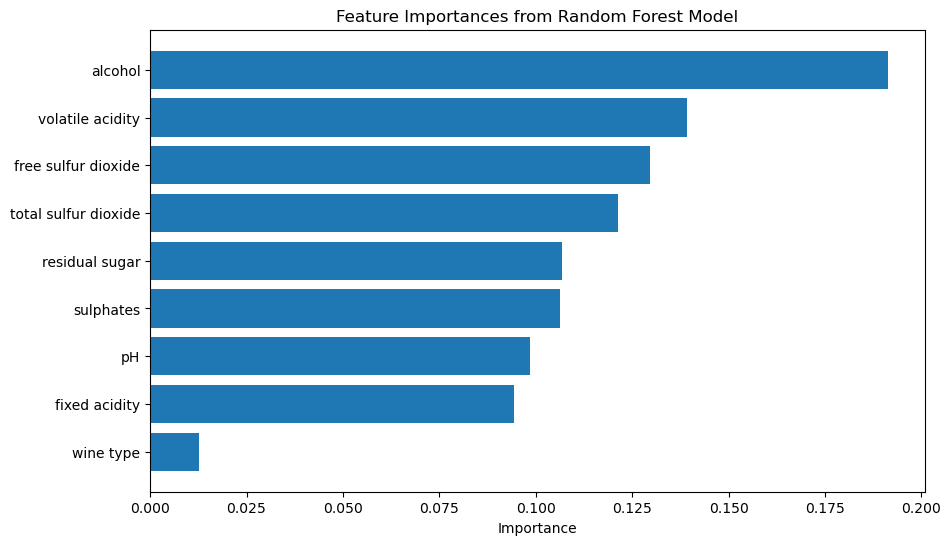

In [145]:
# Feature Importances: 
print(X_train.columns)
print(classifier.feature_importances_)
importances = classifier.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances from Random Forest Model')
plt.gca().invert_yaxis()
plt.show()

In [146]:
# TO DO: find more interesting ways to interpret the results for the presentation 